<a href="https://colab.research.google.com/github/skytecat/DL_study/blob/main/morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [7]:
from google.colab import files
files.upload()  # Загрузите kaggle.json вручную

!mkdir -p ~/.config/kaggle
!mv kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
!kaggle competitions download -c morse-decoder

In [10]:
import zipfile

with zipfile.ZipFile("morse-decoder.zip", 'r') as zip_ref:
    zip_ref.extractall("morse_data")  # Распаковка в папку morse_data

In [28]:
!ls

logbook.txt  morse_dataset  sample_submission.csv  test.csv  train.csv


In [20]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())

       id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ


In [51]:
from sklearn.model_selection import train_test_split

# Разделение (80% train, 20% validation)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,  # Для воспроизводимости
)

print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f'Test: {len(test_df)} samples')

Train: 24000 samples
Validation: 6000 samples
Test: 5000 samples


In [52]:
print(train_data.head(5))

               id     message
21753  21754.opus      РГШ28Ф
251      252.opus     ЦЧАЩ3ДМ
22941  22942.opus  2 М #ЮНЭОП
618      619.opus   ТЪ5Ю6Ы0БХ
17090  17091.opus  ФТЗСК ЙЭФТ


In [212]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Загрузка аудио
file_path = "morse_dataset/morse_dataset/14.opus"
y, sr = librosa.load(file_path, sr=8000)  # Частота 8 кГц, как в задании

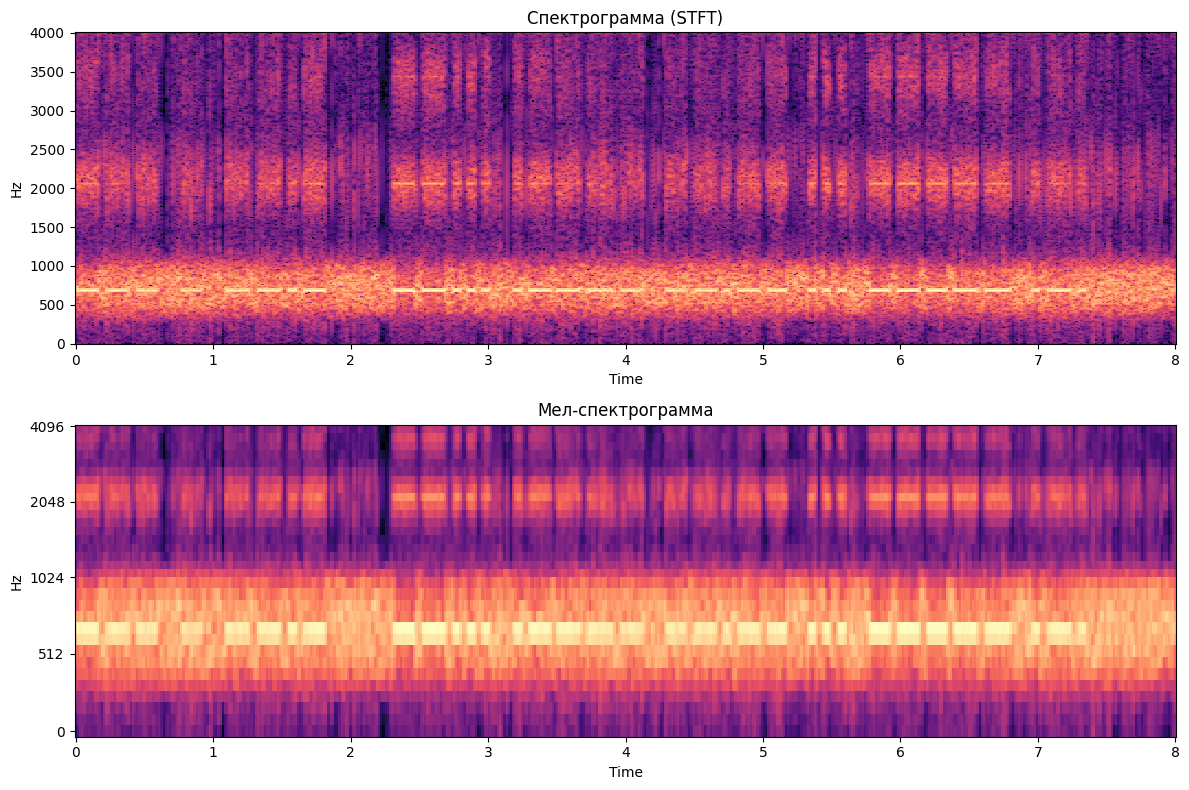

In [213]:
# Спектрограмма
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Отрисовка
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='linear', ax=ax1)
ax1.set_title("Спектрограмма (STFT)")

librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

In [208]:
y_clean = librosa.effects.preemphasis(y)  # Усиление высоких частот
# y_trimmed, _ = librosa.effects.trim(y_clean, top_db=1024)  # Обрезает тихие участки

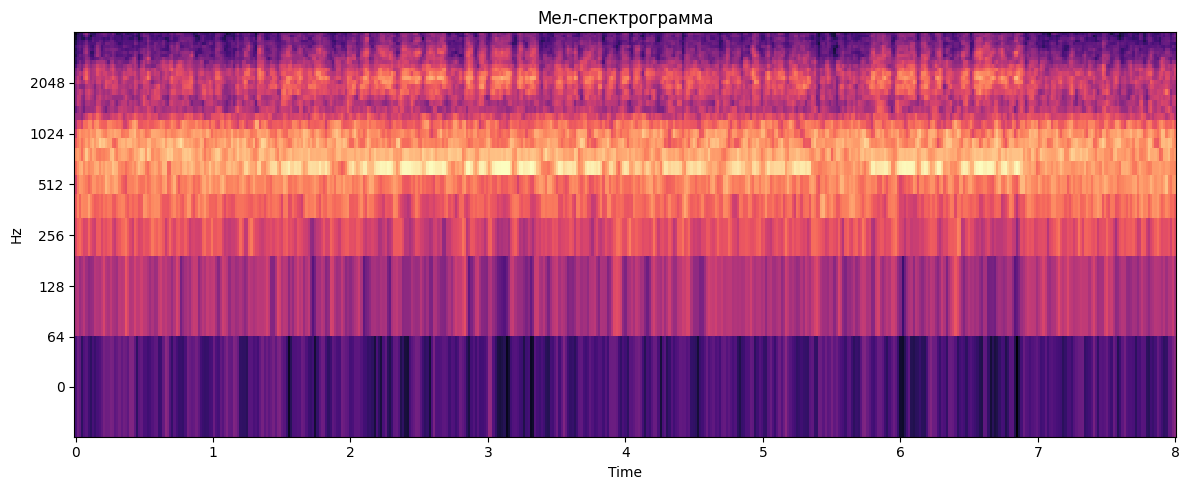

In [209]:
# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y_clean, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std() # нормализация

# Отрисовка
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='log', ax=ax1)

ax1.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

In [196]:
# Определяем диапазон частот для удаления (например, 1000-1500 Гц)
frequencies = librosa.mel_frequencies(n_mels=32, fmin=0, fmax=sr//2)  # Получаем центральные частоты мел-полос
mask = (frequencies < 1024) | (frequencies > 1200)


# Обнуляем ненужные частоты
mel_spec_db_filtered = mel_spec_db.copy()
mel_spec_db_filtered[mask, :] = -80  # -80 dB ~ "тишина"

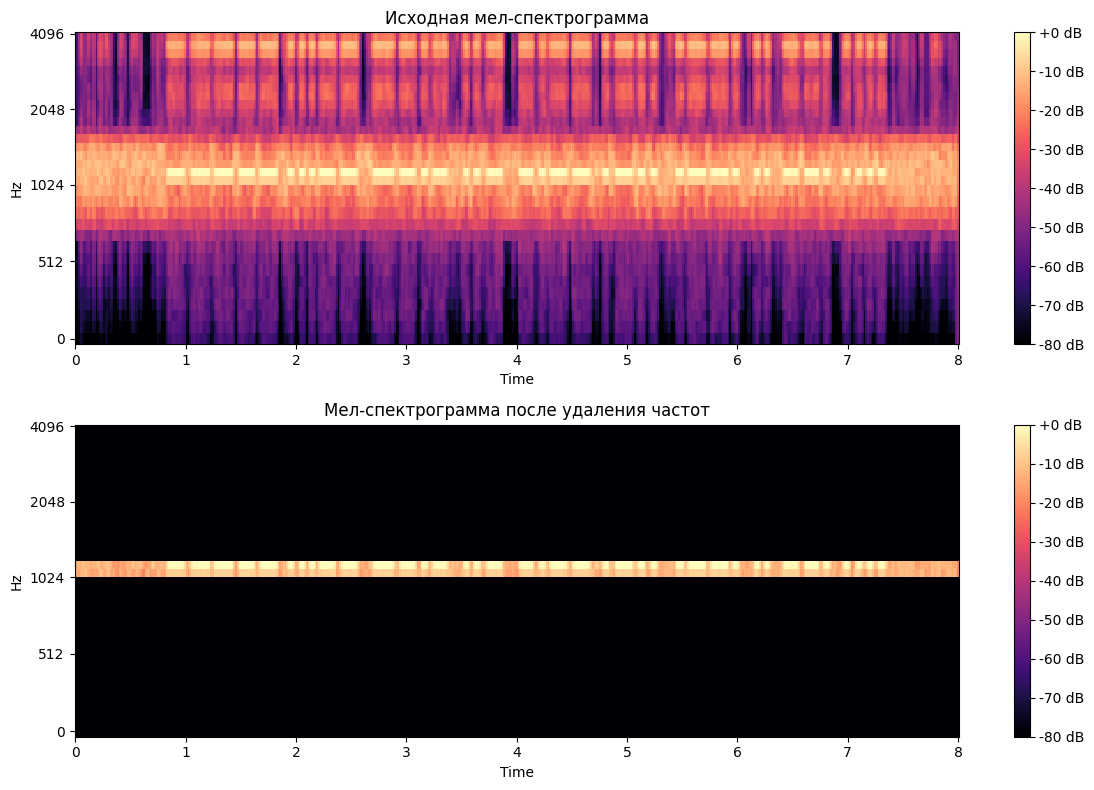

In [197]:
plt.figure(figsize=(12, 8))

# До фильтрации
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Исходная мел-спектрограмма')

# После фильтрации
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_spec_db_filtered, sr=sr, hop_length=128, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Мел-спектрограмма после удаления частот')

plt.tight_layout()
plt.show()

In [165]:
# print(mel_spec_db_filtered[0][:])
print(mel_spec_db_filtered.shape)

(32, 501)


In [166]:
# print(mel_spec[:][0])
print(mel_spec_db.shape)

(32, 501)


In [205]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_paths, sr=8000):
        self.audio_paths = audio_paths
        # self.messages = messages
        self.sr = sr

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        y, _ = librosa.load(self.audio_paths[idx], sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_fft=512, hop_length=128, n_mels=32)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return torch.tensor(mel_spec_db)

# Инициализация
audio_paths = train_data["id"].apply(lambda x: f"morse_dataset/morse_dataset/{x}").tolist()
messages = train_data["message"].tolist()

# dataset = AudioDataset(audio_paths, messages)
dataset = AudioDataset(audio_paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# for batch in dataloader:
    # predictions = model(batch)


torch.Size([32, 501])


In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MorseCRNN(nn.Module):
    def __init__(self, num_classes=3):  # 3 класса: точка, тире, пробел
        super().__init__()
        # CNN часть для извлечения признаков
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # RNN часть для обработки последовательностей
        self.rnn = nn.LSTM(
            input_size=32 * 8,  # Зависит от размеров после CNN
            hidden_size=64,
            bidirectional=True,
            batch_first=True
        )

        # Классификатор
        self.fc = nn.Linear(64 * 2, num_classes)  # x2 для bidirectional

    def forward(self, x):
        # x shape: [batch, 1, n_mels, time]
        x = self.cnn(x)

        # Подготовка для RNN
        batch, channels, freq, time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, freq]
        x = x.reshape(batch, time, -1)  # Объединяем каналы и частоты

        # RNN
        x, _ = self.rnn(x)

        # Классификация
        x = self.fc(x)
        return x  # [batch, time, num_classes]

In [ ]:
def audio_to_mel(audio_path, sr=8000):
    y, sr = librosa.load(audio_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, hop_length=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return torch.tensor(mel_db).unsqueeze(0)  # Добавляем размерность канала

In [220]:
model = MorseCRNN(num_classes=3)
criterion = nn.CTCLoss(blank=0)  # blank класс для CTC
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Пример обучения
for epoch in range(10):
    for batch in dataloader:
        inputs, targets, input_lengths, target_lengths = batch
        outputs = model(inputs)

        # CTC требует особого формата
        outputs = outputs.permute(1, 0, 2)  # [time, batch, classes]
        loss = criterion(outputs, targets, input_lengths, target_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

ValueError: too many values to unpack (expected 4)